In [1]:
import os
import time
import sys
import json
import numpy as np
import ipyvolume as ipv
from pathlib import Path
import numpy as np
import random
import datetime

from tyssue import Monolayer, MonoLayerGeometry, config
from tyssue.io import hdf5
from tyssue.generation import ellipsoid_sheet, extrude
from tyssue.draw import sheet_view
from tyssue.dynamics import effectors

from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.behaviors.events import EventManager
from tyssue.topology.sheet_topology import remove_face
from tyssue.utils.decorators import do_undo
from tyssue.io import hdf5


from invagination.ellipsoid import EllipsoidGeometry as geom
from invagination.ellipsoid import model
from invagination.delamination import (define_mesoderm,
                                       check_enter_in_process,
                                       check_tri_faces,
                                       type1_transition)

from invagination.plots import mesoderm_position


import matplotlib.pyplot as plt

%matplotlib inline

SIM_DIR = Path('/media/data/Simulations/mesoderm_invagination/')
#SIM_DIR = Path('/home/admin-suz/Documents/test')

today = datetime.date.today()

sim_save_dir = SIM_DIR/f'{today.isoformat()}_small_monolayer'
#sim_save_dir = SIM_DIR/f'2018-03-02'
try:
    os.mkdir(sim_save_dir)
except FileExistsError:
    pass

/home/guillaume/miniconda3/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/guillaume/miniconda3/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [26]:
a, b, c = 12., 12., 21.
n_segments = 15


apical_sheet = ellipsoid_sheet(a, b, c, n_segments)
mono_datasets = extrude(apical_sheet.datasets, scale=0.8)
mono = Monolayer('mono', mono_datasets,
                 specs=config.geometry.bulk_spec())
mono.specs['settings']['abc'] = a, b, c

print(f'The tyssue has {mono.Nc} cells')


def draw_specs(sheet):
    specs = {
        'edge': {
            'visible': False,
            'color': sheet.vert_df.y
        },
        'face': {
            'visible': True,
            'color': sheet.face_df.area,
            'colormap': 'Blues'
        }
    }
    return specs


mono.face_df['visible'] = False
posterior_faces = mono.face_df[mono.face_df.z > 0].index
mono.face_df.loc[posterior_faces, 'visible'] = True

ipv.clear()
ipv_fig, meshes = sheet_view(mono, coords=list('zxy'),
                             mode='3D', **draw_specs(mono))
ipv_fig

The tyssue has 243 cells


Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0…

In [3]:
from tyssue.dynamics.factory import model_factory
from tyssue.dynamics import units
from tyssue.dynamics.bulk_gradients import volume_grad

from invagination.ellipsoid import VitellineElasticity
from tyssue.utils import to_nd

In [4]:


class EmbryoGeometry(MonoLayerGeometry):
    
    @classmethod
    def update_all(cls, eptm):

        super().update_all(eptm)
        cls.update_vitelline(eptm)
        cls.update_yolk(eptm)
    
    @staticmethod
    def update_vitelline(eptm):
        a, b, c = eptm.settings['abc']
        vitelline_space = eptm.settings['vitelline_space']
        eptm.vert_df['rho'] = np.linalg.norm(eptm.vert_df[['x', 'y']], axis=1)
        eptm.vert_df['theta'] = np.arcsin((eptm.vert_df.z / c).clip(-1, 1))
        eptm.vert_df['phi'] = np.arctan2(eptm.vert_df.y, eptm.vert_df.x)
        eptm.vert_df['vitelline_rho'] = (
            a + vitelline_space) * np.cos(eptm.vert_df['theta'])

        eptm.vert_df['delta_rho'] = eptm.vert_df.eval(
            'rho - vitelline_rho').clip(lower=0)

    @staticmethod
    def update_yolk(eptm):

        face_pos = eptm.edge_df.loc[eptm.basal_edges,
                                    ['f'+c for c in eptm.coords]].values
        normals = eptm.edge_df.loc[eptm.basal_edges,
                                   eptm.ncoords].values
        sub_yolk_vol = np.sum(-face_pos * normals, axis=1) / 6
        eptm.settings['yolk_vol'] = sub_yolk_vol.sum()

                
class YolkVolumeElasticity(effectors.AbstractEffector):

    dimensions = units.vol_elasticity
    magnitude = 'yolk_elasticity'
    label = 'Yolk volume elasticity'
    element = 'settings'
    spatial_ref = 'yolk_prefered_vol', units.vol

    specs = {
        'settings': {
            'yolk_vol',
            'yolk_elasticity',
            'yolk_prefered_vol'
            }
        }

    @staticmethod
    def energy(eptm):
        Ky, Vy, Vy0 = [eptm.settings[k] for k in
                       ('yolk_elasticity',
                        'yolk_vol',
                        'yolk_prefered_vol')]
        
        return 0.5 * Ky * (Vy - Vy0)**2

    @staticmethod
    def gradient(eptm):
        Ky, Vy, Vy0 = [eptm.settings[k] for k in
                       ('yolk_elasticity',
                        'yolk_vol',
                        'yolk_prefered_vol')]
        
        kv_v0 =  Ky * (Vy - Vy0)

        grad_v_srce, grad_v_trgt = volume_grad(eptm)
        is_basal = to_nd((eptm.edge_df['segment'] == 'basal').astype(int), 3)
        # Minus sign because the yolk is opposite
        grad_v_srce = - kv_v0 * grad_v_srce * is_basal
        grad_v_trgt = - kv_v0 * grad_v_trgt * is_basal

        grad_v_srce.columns = ['g'+u for u in eptm.coords]
        grad_v_trgt.columns = ['g'+u for u in eptm.coords]

        return grad_v_srce, grad_v_trgt


In [5]:
mono.cell_df['vol'].std()

4.068050742125449

In [6]:
mono.settings['vitelline_space'] = 2.
mono.settings['yolk_elasticity'] = 1e-4
EmbryoGeometry.update_all(mono)
mono.settings['yolk_prefered_vol'] = mono.settings['yolk_vol']*1.1
mono.vert_df['vitelline_K'] = 1.

# Modify some initial values

mono.cell_df['prefered_vol'] = mono.cell_df['vol'].mean()
mono.cell_df['prefered_area'] = mono.cell_df['area'].mean()
mono.cell_df['area_elasticity'] = 1e-2
mono.cell_df['vol_elasticity'] = 1.
mono.face_df['surface_tension'] = 1.
mono.edge_df['line_tension'] = 0.


model = model_factory([effectors.CellAreaElasticity,
                       effectors.CellVolumeElasticity,
                       effectors.LineTension,
                       VitellineElasticity,
                       YolkVolumeElasticity,
                       effectors.SurfaceTension
                       ], effectors.CellVolumeElasticity)

print('Our model has the following elements :')
print('\t', *model.labels, sep='\n\t')

Our model has the following elements :
	
	Area elasticity
	Volume elasticity
	Line tension
	Vitelline elasticity
	Yolk volume elasticity
	Surface tension


### Gradient descent

In [7]:
%pdb

Automatic pdb calling has been turned ON


In [10]:
res = Solver.find_energy_min(mono, EmbryoGeometry, model)

In [11]:
ipv.clear()
ipv_fig, meshes = sheet_view(mono, coords=list('zxy'),
                             mode='3D', **draw_specs(mono))
ipv_fig

Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0…

number of apoptotic cells: 30


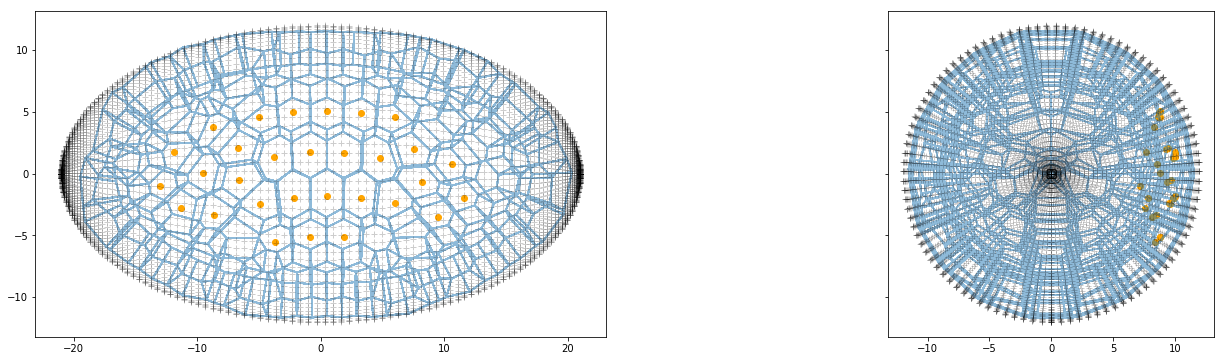

In [12]:
# Define ovoid mesoderm
define_mesoderm(mono, a=12, b=4.)

mesoderm_faces = mono.face_df[mono.face_df.is_mesoderm].index

is_mesoderm_edge = mono.upcast_face(mono.face_df.is_mesoderm)
mesoderm_cells = mono.edge_df[is_mesoderm_edge]['cell'].unique()

print('number of apoptotic cells: {}'.format(mesoderm_cells.size))

fig, axes = plt.subplots(1, 2, sharey=True)

fig, ax = sheet_view(mono, ['z', 'x'], ax=axes[0],
                     mode='quick', edge={"alpha": 0.5})
fig, ax = sheet_view(mono, ['y', 'x'], ax=axes[1],
                     mode='quick', edge={"alpha": 0.5})

axes[0].scatter(mono.cell_df.loc[mesoderm_cells, "z"],
                mono.cell_df.loc[mesoderm_cells, "x"], c='orange')

axes[1].scatter(mono.cell_df.loc[mesoderm_cells, "y"],
                mono.cell_df.loc[mesoderm_cells, "x"], c='orange')
fig.set_size_inches(24, 6)

thetas = np.linspace(-np.pi/2, np.pi/2, 100)
phis = np.linspace(-np.pi, np.pi, 100)

thetas, phis = np.meshgrid(thetas, phis)

vitelline = np.vstack([a * np.cos(thetas.ravel())*np.cos(phis.ravel()),
                       b * np.cos(thetas.ravel())*np.sin(phis.ravel()),
                       c * np.sin(thetas.ravel())])                     
axes[0].plot(vitelline[2, :], vitelline[0, :], 'k+', alpha=0.1)
axes[1].plot(vitelline[1, :], vitelline[0, :], 'k+', alpha=0.1)



In [14]:
from ipywidgets import IntProgress
from IPython.display import display

In [15]:
hdf5.save_datasets('../data/hf5/243_cells_embryo.hf5', mono)
with open('../data/json/243_cells_embryo.json', 'w') as fh:
    json.dump(mono.specs, fh)

/home/guillaume/miniconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2961: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block2_values] [items->['edge_o', 'srce_o', 'trgt_o', 'face_o', 'cell_o', 'segment']]

  exec(code_obj, self.user_global_ns, self.user_ns)
/home/guillaume/miniconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2961: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block3_values] [items->['num_sides', 'face_o', 'segment']]

  exec(code_obj, self.user_global_ns, self.user_ns)


In [160]:
mono.data_names

['cell', 'vert', 'edge', 'face']

In [52]:
datasets = hdf5.load_datasets('../data/hf5/243_cells_embryo.hf5',
                              data_names=['cell', 'vert', 'edge', 'face'])

with open('../data/json/243_cells_embryo.json', 'r') as fh:
    specs = json.load(fh)

mono2 = Monolayer('243', datasets, specs)

# apical faces have the same index as their cells,
face_x = mono2.face_df.loc[mesoderm_cells, 'x']
mono2.face_df.loc[mesoderm_cells, 'surface_tension'] += 10 * np.exp(-(face_x/8)**2)

is_meso_ab = is_mesoderm_edge & (mono.edge_df['segment'] == 'lateral')
meso_ab_edges = mono2.edge_df[is_meso_ab].index

srce_x = mono2.edge_df.loc[meso_ab_edges, 'sx']
mono2.edge_df.loc[meso_ab_edges, 'line_tension'] = 10 * np.exp(-(srce_x/8)**2)



res = Solver.find_energy_min(mono2, EmbryoGeometry, model)



In [51]:
ipv.clear()
mono2.face_df['visible'] = False
posterior_faces = mono2.face_df[mono2.face_df.y  > 0].index
mono2.face_df.loc[posterior_faces, 'visible'] = True

ipv_fig, meshes = sheet_view(mono2, coords=list('zxy'),
                             mode='3D', **draw_specs(mono2))
ipv_fig

Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0…

In [10]:
progress = IntProgress(min=0, max=40)

def run_sim(sheet, mesoderm, geom, model, dirname, progress, stop=40):
    progress.stop=40
   
    display(progress)
    delaminating_cells = []
    #Initiate manager
    manager = EventManager('face')
    sheet.face_df['enter_in_process'] = 0    
    while manager.current and manager.clock < stop:
        # Clean radial tension on all vertices
        sheet.vert_df['radial_tension'] = 0
        manager.execute(sheet)
        res = Solver.find_energy_min(sheet, geom, model, **solver_kw)

        figname = os.path.join(
            dirname, 'invagination_{:04d}.png'.format(manager.clock))
        hdfname = figname[:-3]+'hf5'
        hdf5.save_datasets(hdfname, sheet)      
        
        # Add cells in delamination process if they are authorized
        check_enter_in_process(sheet, manager, mesoderm, amp=0.3, )

        # Add cells with initially 3 neighbourghs to be eliminated
        check_tri_faces(sheet, manager)
        # Add T1 transition for face with at least one edge shorter than critical length
        short_edges = sheet.edge_df['length'] < sheet.settings['threshold_length']
        for face in sheet.edge_df[short_edges]['face'].unique():
            manager.append(type1_transition, face,
                           kwargs={'critical_length':sheet.settings['threshold_length']})    
        manager.update()
        manager.clock += 1
        progress.value = manager.clock
    
    progress.stop = manager.clock
    return sheet

In [11]:

contractility_rate = 2
critical_area = 5
radial_tension = 60

# Directory definition 
dirname = '{}_contractility_{}_critical_area_{}_radialtension'.format(
            contractility_rate, critical_area, radial_tension)
dirname = os.path.join(sim_save_dir, dirname)

print('starting {}'.format(dirname))
try:
    os.mkdir(dirname)
except IOError:
    pass

settings = {'contract_rate': contractility_rate,
            'critical_area': critical_area,
            'radial_tension': radial_tension,
            'nb_iteration': 10,
            'contract_neighbors':False,
            'geom': geom}


# Add some information to the sheet
sheet2 = sheet.copy(deep_copy=True)
sheet2.face_df['id'] = sheet2.face_df.index.values
sheet2.settings['delamination'] = settings

sheet2 = run_sim(sheet2, delaminating_cells, 
                 geom, model, dirname, progress)

print('{} done'.format(dirname))
print('~~~~~~~~~~~~~~~~~~~~~\n')
    

starting /home/admin-suz/Documents/test/2018-09-11_principal_results/2_contractility_5_critical_area_60_radialtension


IntProgress(value=0, max=40)

/home/admin-suz/Documents/test/2018-09-11_principal_results/2_contractility_5_critical_area_60_radialtension done
~~~~~~~~~~~~~~~~~~~~~



In [13]:
hfs = [f  for f in os.listdir(dirname) if f.endswith('hf5')]
hfs.sort()
from tyssue.draw.ipv_draw import edge_mesh, face_mesh

def get_meshes(dirname, hdf_file):
    dsets = hdf5.load_datasets(os.path.join(dirname, hdf_file),
                               data_names=['vert', 'edge', 'face'])
        
    sheet = Sheet('ellipse', dsets)
    faces = face_mesh(sheet, coords=['x', 'y', 'z'],
                      color=sheet.face_df['area'],
                      color_range=(0, 30))
    
    edges = edge_mesh(sheet, coords=['x', 'y', 'z'],
                      color=sheet.vert_df.y)
    return faces, edges

from ipywidgets import interact

def browse_sheets(dirname, hfs):
    n = len(hfs)
    ipv.clear()
    fig = ipv.gcf()
    meshes = get_meshes(dirname, hfs[0])
    fig.meshes = fig.meshes + list(meshes)
    
    def view_sheet(i):
        fig.animation = 0

        faces, edges = get_meshes(dirname, hfs[i])
        print()
        fig.meshes[0].x = faces.x
        fig.meshes[0].y = faces.y
        fig.meshes[0].z = faces.z
        fig.meshes[0].color = faces.color
        fig.meshes[0].triangles = faces.triangles

        fig.meshes[1].x = edges.x
        fig.meshes[1].y = edges.y
        fig.meshes[1].z = edges.z
        fig.meshes[1].color = edges.color
        fig.meshes[1].lines = edges.lines

        lim_inf = sheet.vert_df[sheet.coords].min().min()
        lim_sup = sheet.vert_df[sheet.coords].max().max()
        ipv.xyzlim(lim_inf, lim_sup)
    ipv.show()
    interact(view_sheet, i=(0, n-1))


In [14]:
browse_sheets(dirname, hfs)

VBox(children=(Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array([[0.123463, 0.581687, 0.547445],
       [0.132444, 0.552216, 0.553018],
       [0.124395, 0.578002, 0.548287],
       ...,
       [0.122312, 0.633153, 0.530398],
       [0.122312, 0.633153, 0.530398],
       [0.123463, 0.581687, 0.547445]]), texture=None, triangles=array([[ 150,  184, 1272],
       [  30,  185, 1273],
       [ 150,  186, 1274],
       ...,
       [  60, 1269, 2357],
       [  59, 1270, 2358],
       [   0, 1271, 2359]], dtype=uint32), x=array([-3.49167177, -0.61424217,  0.35327774, ...,  6.59439018,
        6.46668453, -2.987343  ]), y=array([  7.32072946,   5.70744258,   8.80855614, ...,  -9.99153044,
       -10.3459322 ,   5.92303969]), z=array([-13.77843317, -15.98479101, -12.86573139, ...,  -4.05431767,
        -0.09969878, -15.6421147 ])), Mesh(color=array([[0.525776, 0.833491, 0.288127],
       [0.227802, 0.326594, 0.546532],
       [0.277134, 0.185228, 0.489898],
       ...,
       [0.162142, 0.474838, 0.55814 ],
       [0.154815, 0.493313, 0.55784 ],
       [0.171176, 0.45253 , 0.557965]]), lines=array([[351, 350],
       [285, 187],
       [304, 351],
       ...,
       [147,  41],
       [149, 148],
       [  0, 115]], dtype=uint32), texture=None, x=array([ -1.29123732,  -2.987343  ,  -4.1007321 ,  -2.82883767,
        -1.94079255,  -3.26429561,  -7.4940199 ,  -9.95701468,
        -8.38961323,  -4.04481303,  -3.20848191,  -6.23742063,
        -6.28121277,  -7.06070154,  -2.31187099,  -1.98038799,
        -3.19862225,   1.19919938,   1.85437658,  -6.05747408,
         9.42048041,   6.59439018,   9.76886818,   8.81352722,
         0.71973191,   6.71238814,   6.35824249,  -7.39857417,
        -5.76683297,  -8.34636821,  -4.48969656,  -7.4940199 ,
        -9.95701468,  -8.38961323, -11.85960206, -10.30018537,
        -9.74565694, -11.85960206, -10.30018537,  -9.74565694,
         9.42048041,   6.59439018,   9.76886818,   8.81352722,
        11.79403639,   9.88967056,   9.28216399,  11.79403639,
         9.88967056,   9.28216399,   6.71238814,   6.35824249,
        -2.52451774,  -2.28527897,  -3.25355023,   1.02445308,
        -7.39857417,  -5.76683297,  -4.81700626,  -8.34636821,
         3.21700962,   0.33286044,   1.48132752,   0.71973191,
        -1.29123732,  -1.98687897,   7.71997621,   4.58448403,
       -10.81126822,  -4.1007321 ,  -4.48969656,  -1.98687897,
        -2.01898864,   0.21066694,  -0.49548836,  -9.65115711,
       -10.20054131,  -9.65115711, -10.20054131,  -8.11812626,
        -8.9728952 ,  -5.93223444,  -7.21233068,  -5.76835445,
         3.51783346,   7.48208451,   6.17895856,  -7.57701253,
        -7.35528898,  -9.91428721,  -5.39803802,  -6.36609988,
        -6.72599638,  11.91199162,  11.91199162,  10.69765348,
        10.69765348,  11.58159631,  11.58159631,   9.89810958,
        11.03390251,  10.85043924,   8.5941055 ,   9.20258641,
         7.71997621,   1.48132752,   1.2614291 ,   2.38470434,
         2.4516568 ,   5.46187221,   6.46668453,   5.52746934,
         3.98640786,   8.80301023,  10.58663736,  -2.987343  ,
        -4.81700626,  -4.04481303,  -7.74868876,  -7.74868876,
        -5.80032787,  -6.25396504,  -5.80032787,  -6.25396504,
        -8.11812626,  -8.9728952 ,  -5.93223444,  -7.21233068,
        -5.76835445, -12.02865212, -12.02865212,  -3.20848191,
        -1.98038799,  -3.19862225,  -6.23742063,  -6.28121277,
        -7.06070154,   9.89810958,  11.03390251,  10.85043924,
         8.5941055 ,   9.20258641,  11.97337871,  11.97337871,
         1.2614291 ,   2.38470434,   2.4516568 ,   5.46187221,
         6.46668453,   5.52746934,   7.03722374,   8.67051987,
         7.6482453 ,   3.98640786,   1.60034567,   0.21066694,
         5.37819831,   7.42176513, -11.96663332, -11.96663332,


interactive(children=(IntSlider(value=15, description='i', max=30), Output()), _dom_classes=('widget-interact',))